## Querying Inferences

ArthurAI exposes a very flexible query interface so you can quickly slice and dice metrics about your model's inputs and outputs. In this notebook, we walk through a few examples of how data scientists might track a model's stability and metrics. 

These queries are conducted using a SQL-like language and the results can be easily dropped into a pandas DataFrame for plotting.

To learn more about the full details of what is possible, please view the [Query Guide and Documentation](https://docs.arthur.ai/api-documentation/query_guide.html). Many aggregations, transformations, and helper functions are available. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from arthurai import ArthurAI
from arthurai.client.apiv3 import Stage

In [17]:
ACCESS_KEY = "..."
connection = ArthurAI(url = "https://app.arthur.ai", access_key = ACCESS_KEY)
arthur_model = connection.get_model("RiskModel_v1.0.1", id_type="partner_model_id")

#### Model outputs over time
We might be interested in the stability/drift of the model's output predictions over time. We can summarize the classifier's average predicted probability (termed "prediction_1" below) and see how this changes from batch to batch.

In this example, we use the "avg" aggregator, as well as grouping by "batch_id".

([], [])

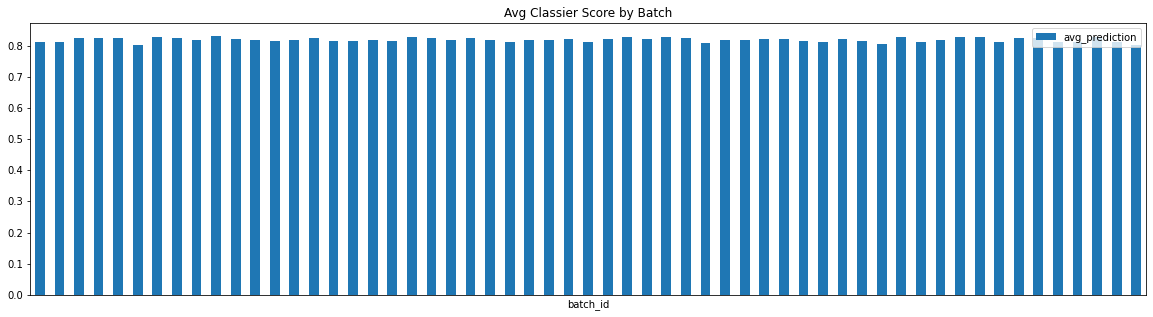

In [21]:
body = {
    "select": [
        {
            "function": "avg",
            "alias": "avg_prediction",
            "parameters": {
                "property": "prediction_1"
            }
        },
        {
            "property": "batch_id"
        }
    ],
    "group_by": [
        {
            "property": "batch_id"
        }
    ]
}

result = arthur_model.query(body)
pd.DataFrame(result).plot.bar(x="batch_id", y="avg_prediction", figsize=(20,5))
plt.title("Avg Classier Score by Batch")
plt.xticks([])

#### Positive Rate over time
Instead of the average predicted score, we might be interested in something more explicit such as the classifier's resulting positive rate subject to a threshold. In this example, we use the "rate" function and supply a threshold for comparison.

Text(0.5, 1.0, 'Classifier Positive Rate per Batch at Threshold=0.9')

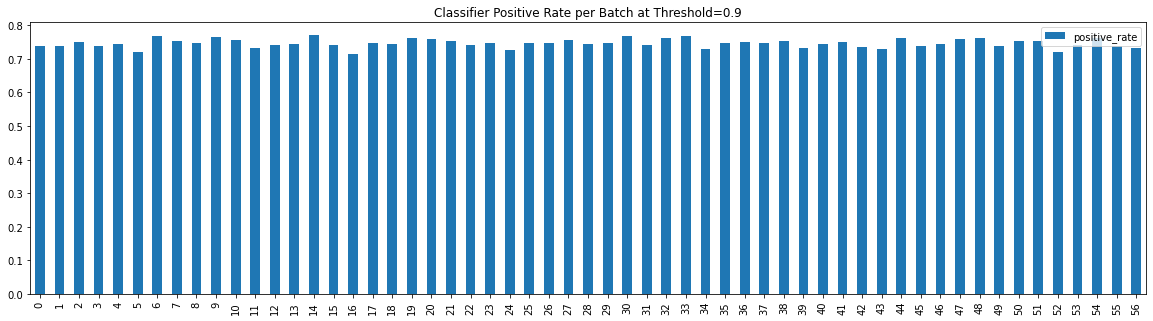

In [24]:
# positive rate
classifier_threshold = 0.9
body = {
    "select": [
        {
            "function": "rate",
            "alias": "positive_rate",
            "parameters": {
                "property": "predicted_1",
                "comparator": "gt",
                "value": classifier_threshold
            }
        },
        {
            "property": "batch_id"
        }
    ],
    "group_by": [
        {
            "property": "batch_id"
        }
    ]
}

res = arthur_model.query(body)
pd.DataFrame(res).plot.bar(figsize=(20,5))
plt.title(f"Classifier Positive Rate per Batch at Threshold={classifier_threshold}")

#### Viziualizing the distribution of a variable
We can also visualize the distribution of a variable over all observed infereces. For a discrete variable, we can use the "count" function. 

<AxesSubplot:xlabel='EDUCATION'>

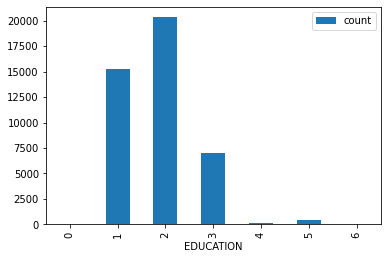

In [50]:
feature_name = "EDUCATION"
body = {
    "select": [
        {
            "property": feature_name
        },
        {
            "function": "count"
        }
    ],
    "group_by": [
        {
            "property": feature_name
        }
    ],
    "order_by": [
        {
            "property": feature_name
        }
    ]
}


response = arthur_model.query(body)
pd.DataFrame(response).plot.bar(x="EDUCATION")

#### Viziualizing the distribution of a variable
For a continous variable, we can use the [distribution](https://docs.arthur.ai/api-documentation/query_guide.html#distribution) function.

In [108]:
feature_name = "Predicted_FICO_Score"
body =  {
    "select": [
        {
            "function": "distribution",
            "parameters": {
                "property": feature_name,
                "num_bins": 25
            }
        }
    ]
}

response = arthur_model.query(body)

Text(0, 0.5, 'Count')

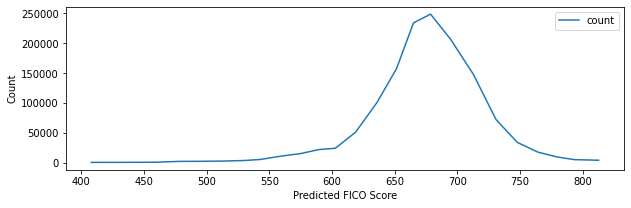

In [111]:
pd.DataFrame(response[0]["distribution"]).plot.line(x="upper", y="count", figsize=(10,3))
plt.xlabel("Predicted FICO Score")
plt.ylabel("Count")

#### Time slicing
We can easily filter down to specific timeframes for comparison, using the "filter" operation.

<AxesSubplot:xlabel='EDUCATION'>

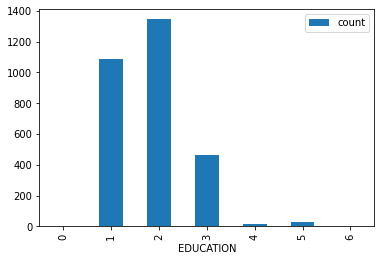

In [54]:
feature_name = "EDUCATION"

body = {
    "select": [
        {
            "property": feature_name
        },
        {
            "function": "count"
        }
    ],
    "filter": [
        {
            "property": "inference_timestamp",
            "comparator": "gte",
            "value": "2020-10-22T10:00:00Z"
        },
        {
            "property": "inference_timestamp",
            "comparator": "lt",
            "value": "2020-10-24T11:00:00Z"
        }
    ],
    "group_by": [
        {
            "property": feature_name
        }
    ],
    "order_by": [
        {
            "property": feature_name
        }
    ]
}


response = arthur_model.query(body)
pd.DataFrame(response).plot.bar(x="EDUCATION")

#### Viziualizing the distribution of a variable over time
Or, we can visulize the distribution of a variable over time by using the "roundTimestamp" function to aggregate into time windows such as minutely, hourly, daily, or per batch.

In [55]:
feature_name = "EDUCATION"


body = {
    "select": [
        {
            "property": feature_name
        },
        {
            "function": "count"
        },
        {
            "function": "roundTimestamp",
            "alias": "day",
            "parameters": {
                "property": "inference_timestamp",
                "time_interval": "day"
            }
        }
    ],
    "group_by": [
        {
            "property": feature_name
        },
        {
            "alias": "day"
        }
    ],
    "order_by": [
        {
            "property": feature_name
        }
    ]
}


response = arthur_model.query(body)

<AxesSubplot:xlabel='day'>

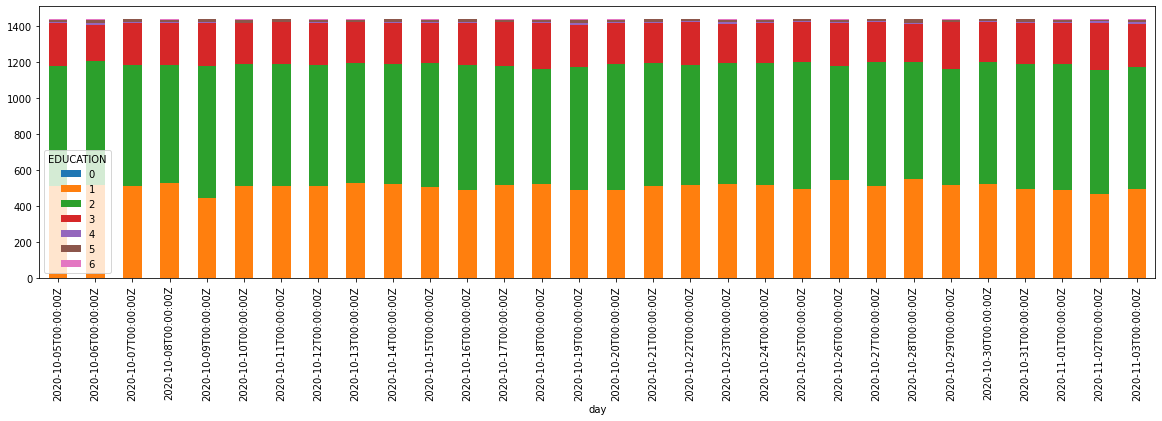

In [56]:
pd.DataFrame(response).pivot(index="day",columns=feature_name, values="count").plot.bar(figsize=(20,5), stacked=True)

#### Predictions over time per demographic groups
We can also visualize a model's output predictions and segment and slice the data along any relevant dimensions. For example, let's look at the average prediction from a regression model, and group by another variable such as Gender. And we'll also group by "day" so we can see how this model's predictions drift over time.

FixedFormatter should only be used together with FixedLocator


Text(0, 0.5, 'Average Prediction')

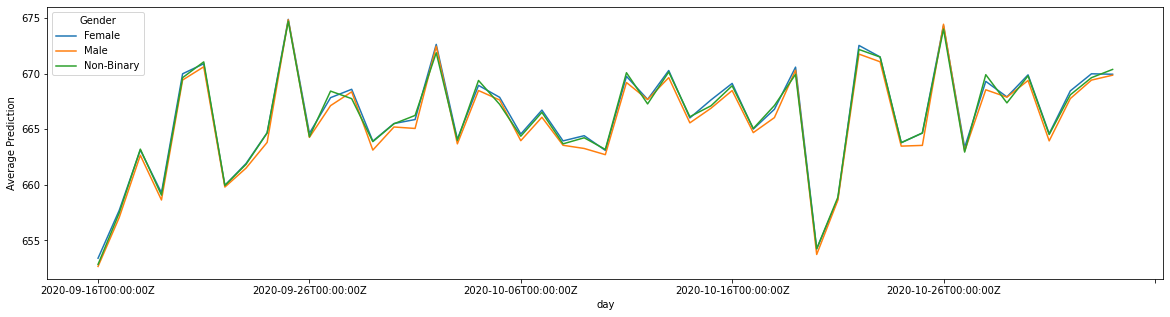

In [78]:
body = {
    "select": [
        {
            "function": "avg",
            "alias": "average_prediction",
            "parameters": {
                "property": "Predicted_FICO_Score"
            }
        },
        {
            "function": "roundTimestamp",
            "alias": "day",
            "parameters": {
                "property": "inference_timestamp",
                "time_interval": "day"
            }
        },
        {
            "property": "Gender"
        }
    ],
    "group_by": [
        {
            "property": "Gender"
        },
        {
            "alias": "day"
        }
    ]
}
response = arthur_model.query(body)
pd.DataFrame(response).pivot(index="day",columns="Gender", values="average_prediction").plot.line(figsize=(20,5))
plt.ylabel("Average Prediction")

These few examples show the just beginning of questions you can ask and metrics you can pull from the Arthur platform. 

For full details, please view the [Query Guide and Documentation](https://docs.arthur.ai/api-documentation/query_guide.html).